In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
BASE_DIR = "C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\archive\\utkface_aligned_cropped\\UTKFace"

In [5]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  100       0
1  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  100       0
2  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  100       1
3  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  100       1
4  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  100       1

In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

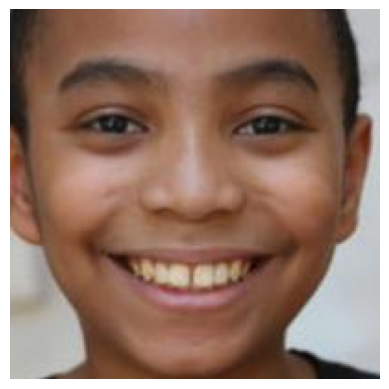

In [8]:
from PIL import Image
img = Image.open(df['image'][87])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

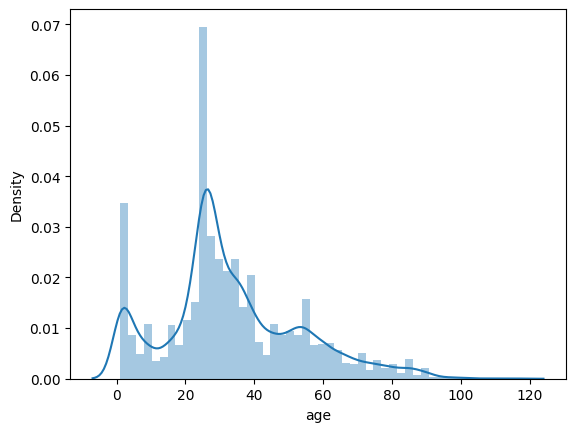

In [9]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

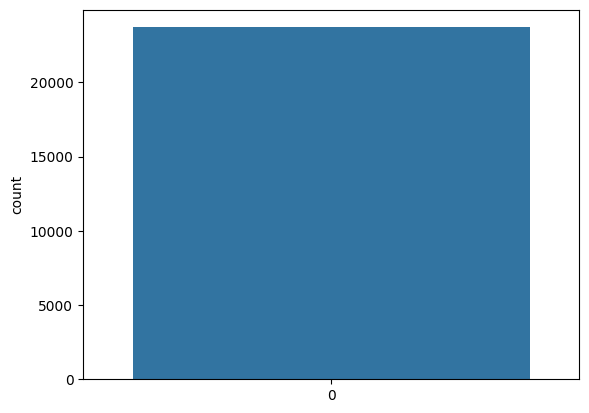

In [10]:
sns.countplot(df['gender'])

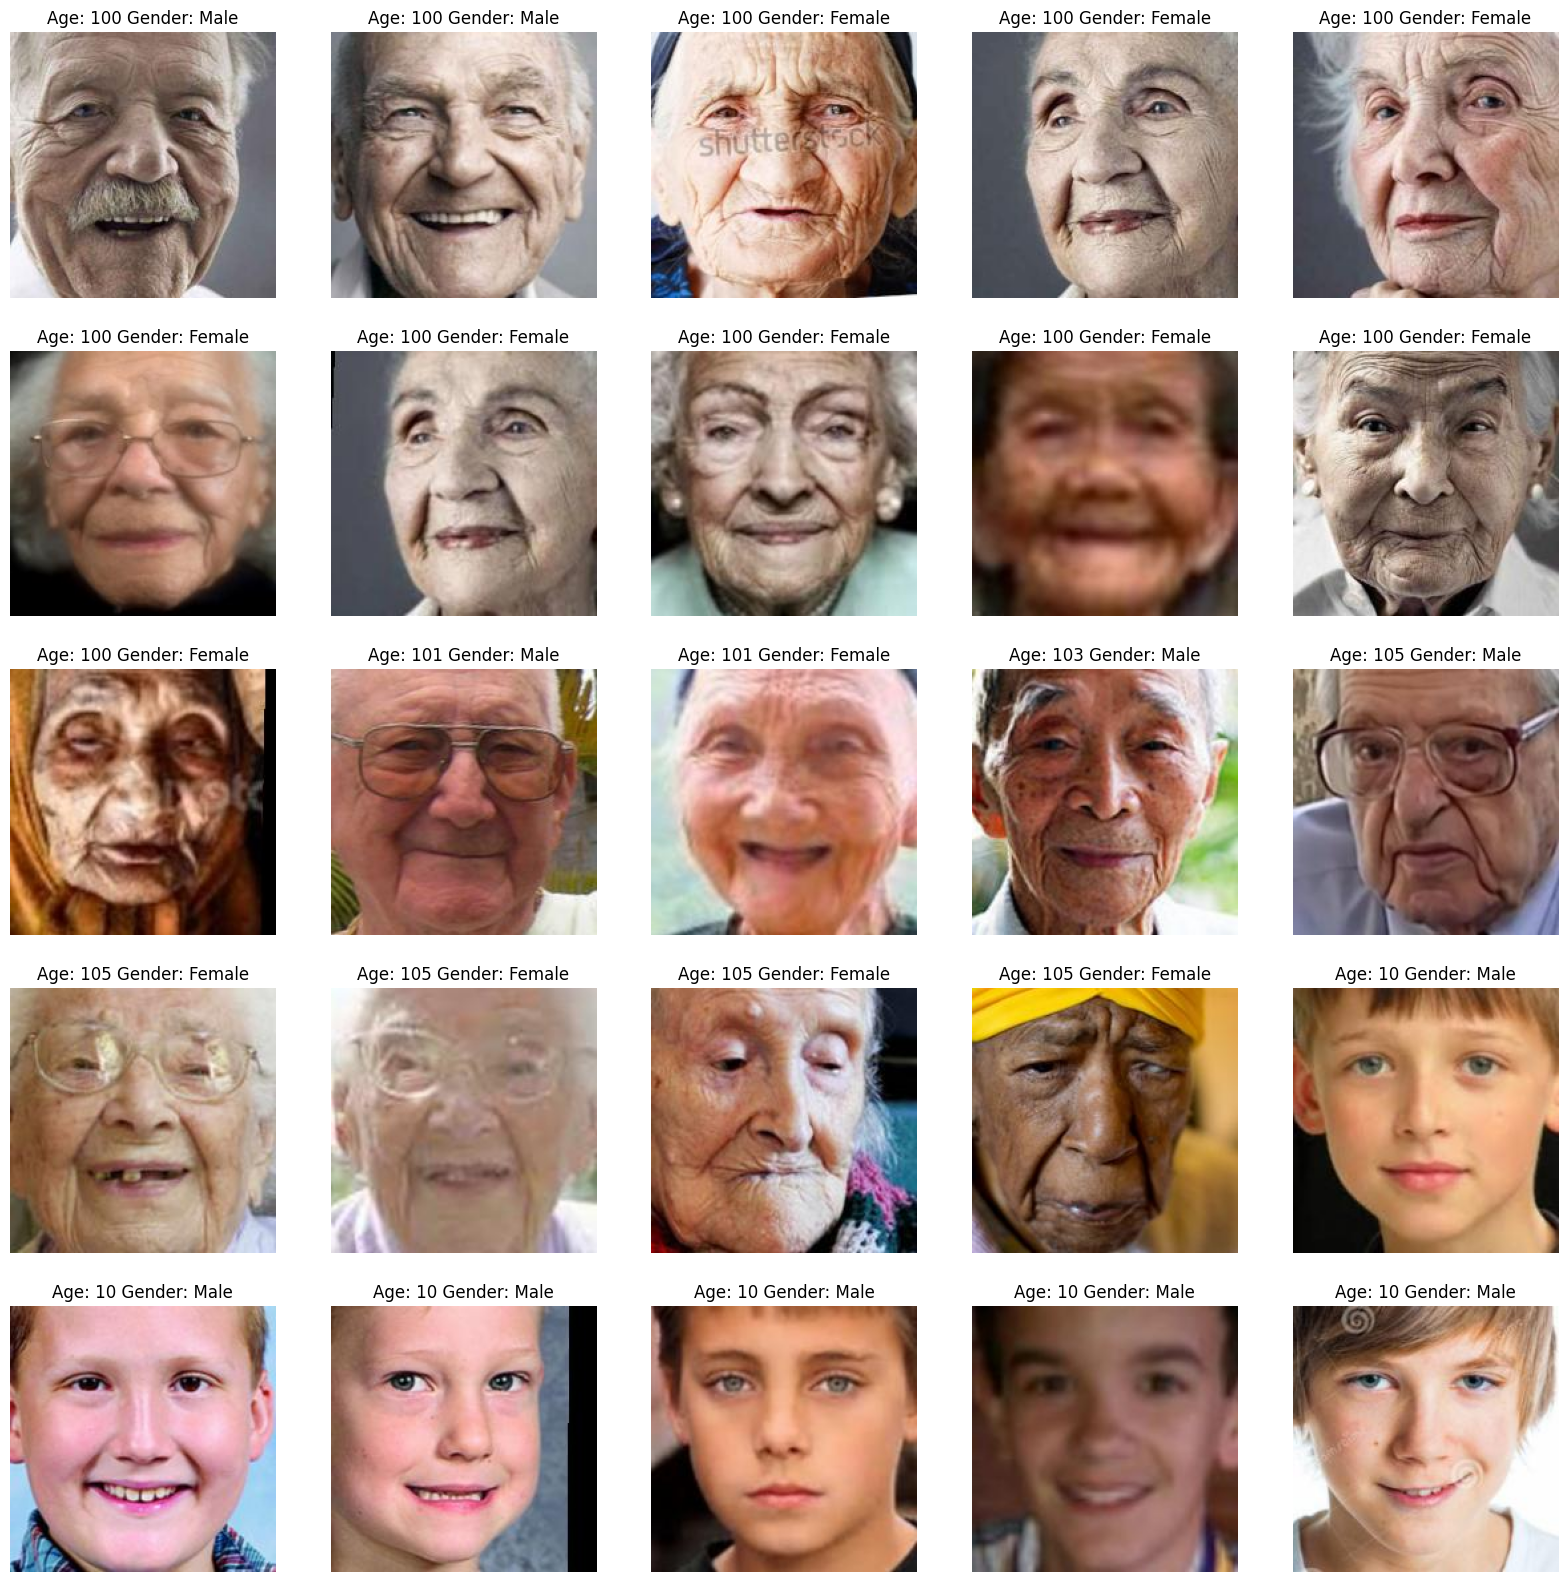

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
# normalize the images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 377s 629ms/step - loss: 11.2104 - gender_out_loss: 0.7021 - age_out_loss: 10.5082 - gender_out_accuracy: 0.5132 - age_out_accuracy: 0.0592 - val_loss: 36.6063 - val_gender_out_loss: 0.6679 - val_age_out_loss: 35.9385 - val_gender_out_accuracy: 0.6295 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 370s 623ms/step - loss: 8.9110 - gender_out_loss: 0.5087 - age_out_loss: 8.4023 - gender_out_accuracy: 0.7429 - age_out_accuracy: 0.0506 - val_loss: 28.5752 - val_gender_out_loss: 0.5044 - val_age_out_loss: 28.0708 - val_gender_out_accuracy: 0.7695 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 373s 629ms/step - loss: 7.4571 - gender_out_loss: 0.3859 - age_out_loss: 7.0712 - gender_out_accuracy: 0.8247 - age_out_accuracy: 0.0264 - val_loss: 31.0374 - val_gender_out_loss: 0.4669 - val_age_out_loss: 30.5705 - val_gender_out_accuracy: 0.7815 - val_age_out_accur

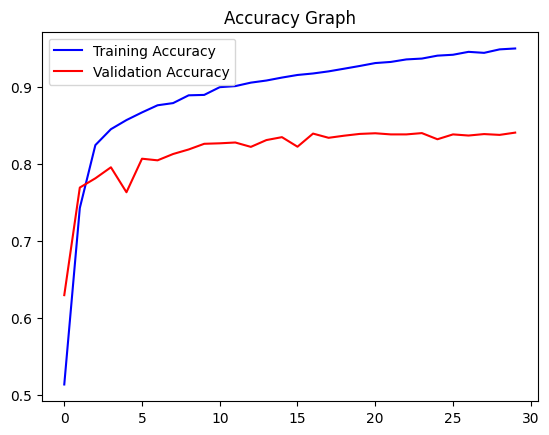

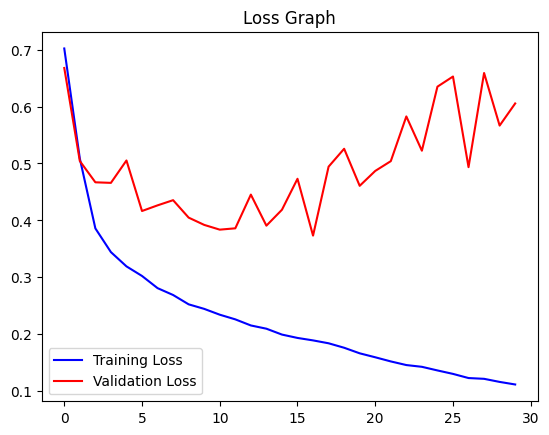

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

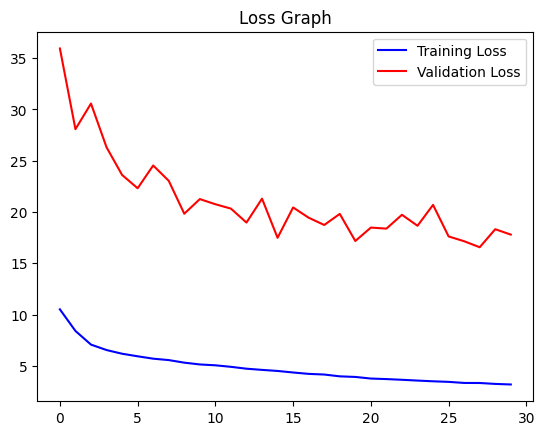

In [22]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 231ms/step
Predicted Gender: Male Predicted Age: 14


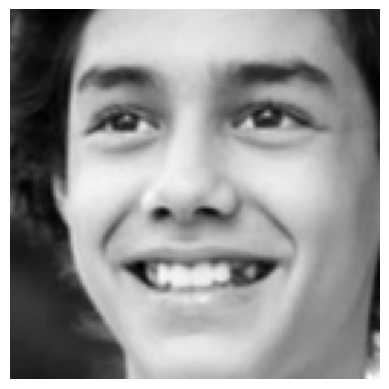

In [23]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 [==============================] - 0s 32ms/step
Predicted Gender: Male Predicted Age: 22


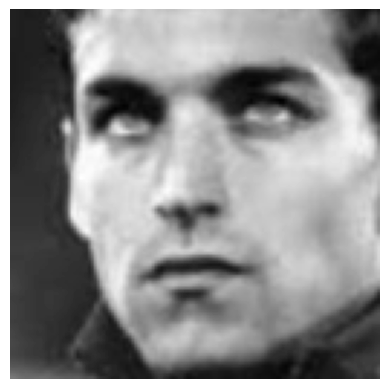

In [24]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 32ms/step
Predicted Gender: Female Predicted Age: 30


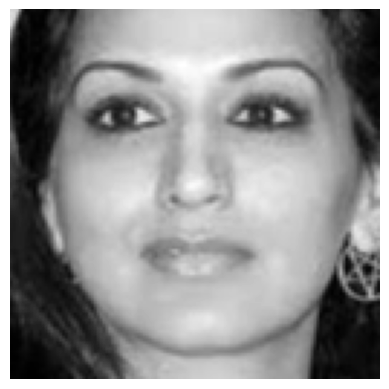

In [25]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [2]:
TRAIN_DIR = "C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\train\\train\\"
TEST_DIR = "C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\test\\test\\"

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
def load_dataset(directory):
    image_paths1 = []
    labels1 = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path1 = os.path.join(directory, label, filename)
            image_paths1.append(image_path1)
            labels1.append(label)
            
        print(label, "Completed")
        
    return image_paths1, labels1

In [5]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed


image    label
0  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  neutral
1  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...    happy
2  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...    angry
3  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...    angry
4  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...    angry

In [6]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


image  label
0  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  angry
1  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  angry
2  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  angry
3  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  angry
4  C:\Users\aryan\OneDrive\Desktop\6th_Sem\MY\Pro...  angry

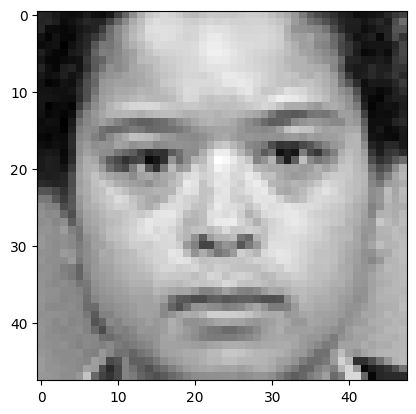

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

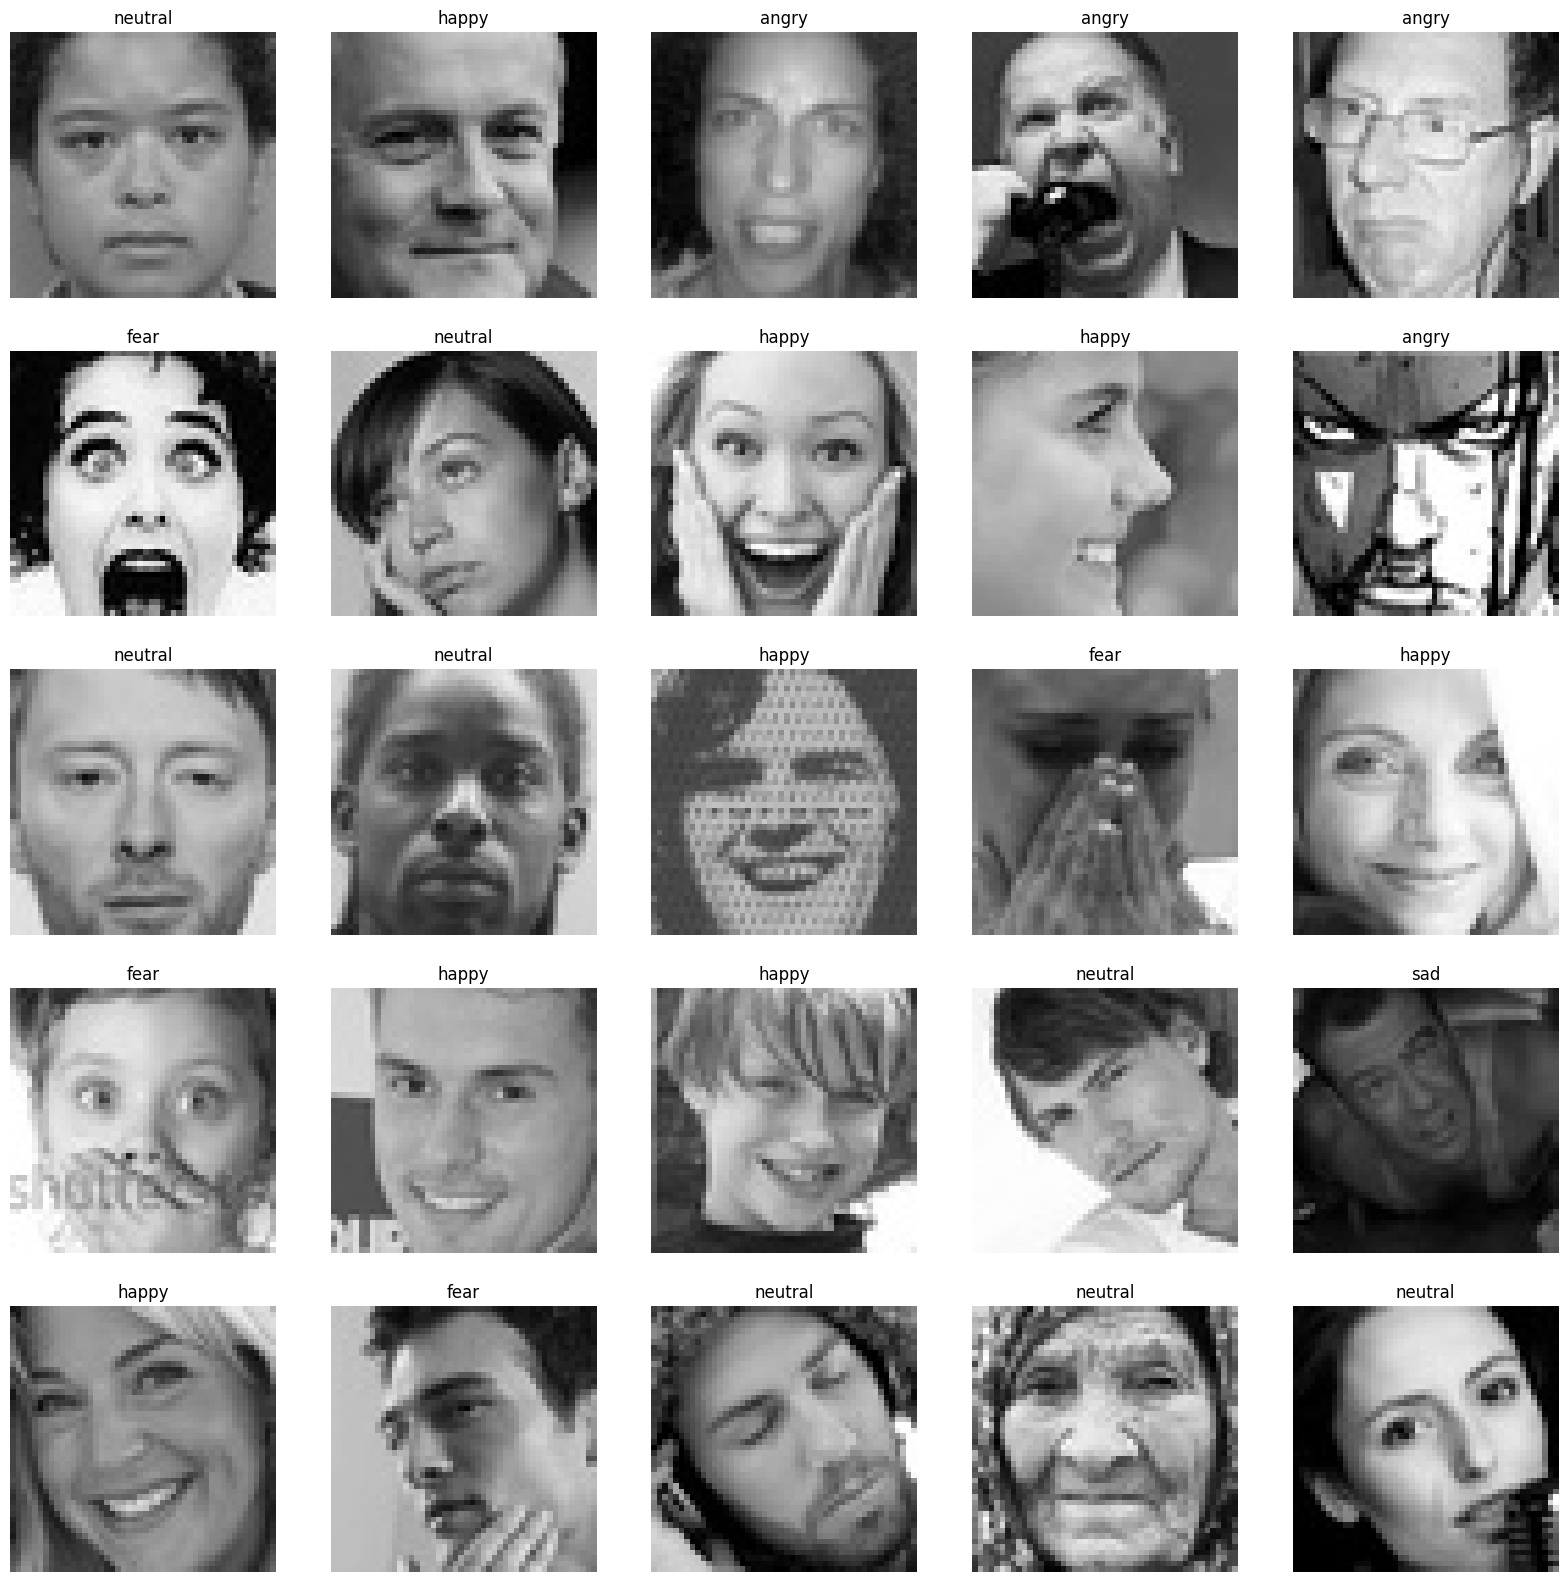

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/25211 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [12]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder


In [14]:
le1 = LabelEncoder()
le1.fit(train['label'])
y_train = le1.transform(train['label'])

In [15]:
le2 = LabelEncoder()
y_test = le2.fit_transform(test['label'])

In [16]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [17]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [18]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [19]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [20]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
197/197 [==============================] - 537s 3s/step - loss: 1.6702 - accuracy: 0.2755 - val_loss: 2.1026 - val_accuracy: 0.2471
Epoch 2/10
197/197 [==============================] - 534s 3s/step - loss: 1.6465 - accuracy: 0.2865 - val_loss: 2.2744 - val_accuracy: 0.2556
Epoch 3/10
197/197 [==============================] - 543s 3s/step - loss: 1.6246 - accuracy: 0.2956 - val_loss: 2.4310 - val_accuracy: 0.2749
Epoch 4/10
197/197 [==============================] - 540s 3s/step - loss: 1.5915 - accuracy: 0.3176 - val_loss: 2.1869 - val_accuracy: 0.3261
Epoch 5/10
197/197 [==============================] - 547s 3s/step - loss: 1.5108 - accuracy: 0.3750 - val_loss: 2.3155 - val_accuracy: 0.3711
Epoch 6/10
197/197 [==============================] - 543s 3s/step - loss: 1.4382 - accuracy: 0.4134 - val_loss: 2.3710 - val_accuracy: 0.3980
Epoch 7/10
197/197 [==============================] - 544s 3s/step - loss: 1.3867 - accuracy: 0.4394 - val_loss: 2.3216 - val_accuracy: 0.4291

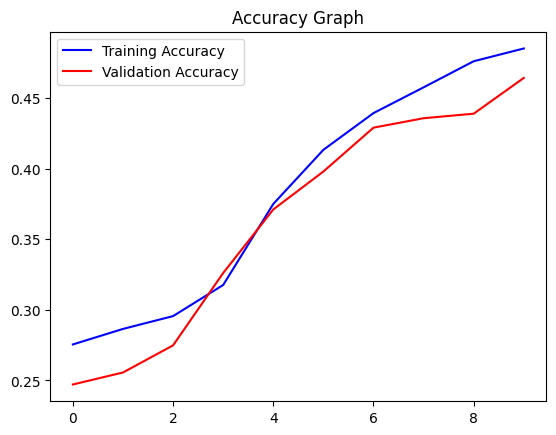

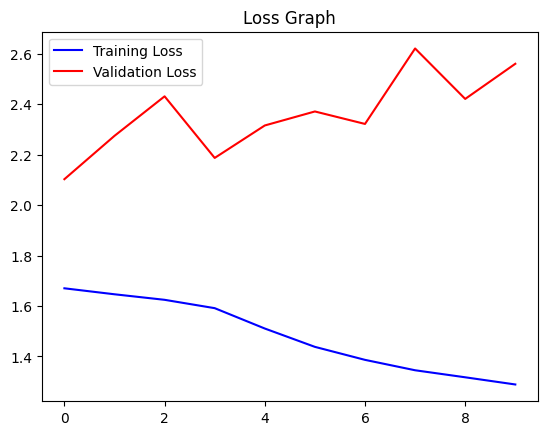

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [23]:
import random

Original Output: sad
1/1 [==============================] - 0s 33ms/step
Predicted Output: neutral


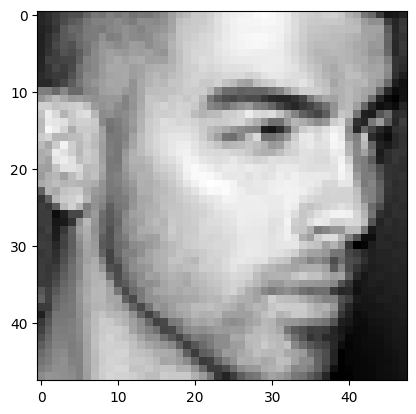

In [25]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le1.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: sad
1/1 [==============================] - 0s 44ms/step
Predicted Output: neutral


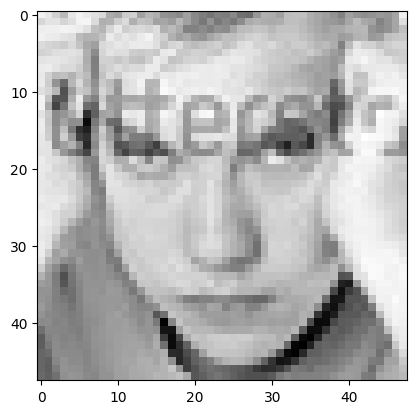

In [26]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le1.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 [==============================] - 0s 30ms/step
Predicted Output: neutral


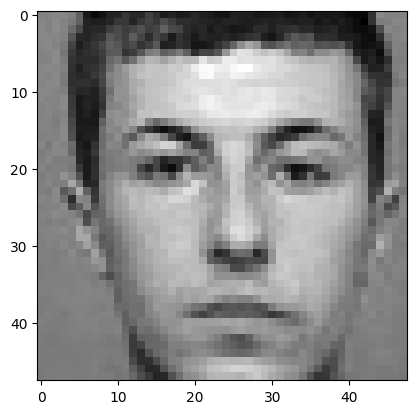

In [27]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le2.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image 
from sklearn.model_selection import train_test_split

In [2]:
with_mask_files = os.listdir("C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\data\\with_mask")
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['with_mask_1.jpg', 'with_mask_10.jpg', 'with_mask_100.jpg', 'with_mask_1000.jpg', 'with_mask_1001.jpg']
['with_mask_995.jpg', 'with_mask_996.jpg', 'with_mask_997.jpg', 'with_mask_998.jpg', 'with_mask_999.jpg']


In [3]:
without_mask_files = os.listdir("C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\data\\without_mask")
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['without_mask_1.jpg', 'without_mask_10.jpg', 'without_mask_100.jpg', 'without_mask_1000.jpg', 'without_mask_1001.jpg']
['without_mask_995.jpg', 'without_mask_996.jpg', 'without_mask_997.jpg', 'without_mask_998.jpg', 'without_mask_999.jpg']


In [4]:
print('Number of with mask images:', len(with_mask_files))
print('Number of without mask images:', len(without_mask_files))

Number of with mask images: 3725
Number of without mask images: 3828


In [5]:
# create the labels

with_mask_labels = [1]*3725

without_mask_labels = [0]*3828

In [6]:
print(with_mask_labels[0:5])

print(without_mask_labels[0:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [7]:
print(len(with_mask_labels))
print(len(without_mask_labels))

3725
3828


In [8]:
labels = with_mask_labels + without_mask_labels

print(len(labels))
print(labels[0:5])
print(labels[-5:])

7553
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


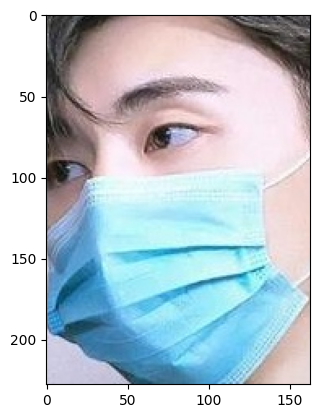

In [9]:
# displaying with mask image
img = mpimg.imread("C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\data\\with_mask\\with_mask_1545.jpg")
imgplot = plt.imshow(img)
plt.show()

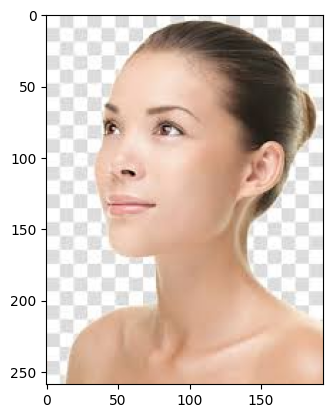

In [10]:
# displaying without mask image
img = mpimg.imread("C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\data\\without_mask\\without_mask_2925.jpg")
imgplot = plt.imshow(img)
plt.show()

In [11]:
# convert images to numpy arrays+

with_mask_path = "C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\data\\with_mask\\"

data = []

for img_file in with_mask_files:

  image = Image.open(with_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)



without_mask_path = "C:\\Users\\aryan\\OneDrive\\Desktop\\6th_Sem\\MY\\Projects\\TTL Project\\data\\without_mask\\"


for img_file in without_mask_files:

  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

C:\Users\aryan\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
type(data)

list

In [13]:
len(data)

7553

In [14]:
data[0]

array([[[50, 58, 31],
        [46, 55, 33],
        [56, 58, 42],
        ...,
        [27, 32, 25],
        [29, 33, 19],
        [33, 40, 17]],

       [[47, 54, 30],
        [49, 58, 36],
        [59, 63, 40],
        ...,
        [18, 21, 11],
        [37, 42, 31],
        [31, 41, 23]],

       [[51, 58, 37],
        [50, 59, 37],
        [59, 64, 37],
        ...,
        [45, 44, 30],
        [29, 34, 27],
        [20, 30, 18]],

       ...,

       [[63, 73, 37],
        [66, 75, 41],
        [74, 84, 50],
        ...,
        [ 5,  3,  0],
        [20, 19, 14],
        [17, 16, 12]],

       [[58, 72, 34],
        [60, 70, 39],
        [68, 75, 49],
        ...,
        [16, 15, 12],
        [15, 13, 10],
        [13,  9,  7]],

       [[53, 69, 30],
        [53, 64, 37],
        [57, 64, 42],
        ...,
        [18, 18, 16],
        [16, 13, 12],
        [19, 12, 13]]], dtype=uint8)

In [15]:
type(data[0])

numpy.ndarray

In [16]:
data[0].shape

(128, 128, 3)

In [17]:
# converting image list and label list to numpy arrays

X = np.array(data)
Y = np.array(labels)

In [18]:
type(X)

numpy.ndarray

In [19]:
type(Y)

numpy.ndarray

In [20]:
print(X.shape)
print(Y.shape)

(7553, 128, 128, 3)
(7553,)


In [21]:
print(Y)

[1 1 1 ... 0 0 0]


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [23]:
print(X.shape, X_train.shape, X_test.shape)

(7553, 128, 128, 3) (6042, 128, 128, 3) (1511, 128, 128, 3)


In [24]:
# scaling the data

X_train_scaled = X_train/255

X_test_scaled = X_test/255

In [25]:
X_train[0]

array([[[226, 234, 201],
        [211, 216, 188],
        [188, 188, 169],
        ...,
        [186, 181, 165],
        [179, 175, 150],
        [166, 181, 136]],

       [[224, 228, 218],
        [201, 204, 195],
        [201, 199, 192],
        ...,
        [197, 190, 182],
        [175, 170, 153],
        [162, 180, 143]],

       [[205, 204, 212],
        [221, 220, 226],
        [195, 192, 196],
        ...,
        [183, 174, 173],
        [172, 167, 159],
        [181, 199, 171]],

       ...,

       [[156, 176, 197],
        [159, 180, 196],
        [164, 185, 196],
        ...,
        [ 89,  99,  71],
        [106, 113,  83],
        [ 99, 103,  68]],

       [[151, 177, 196],
        [167, 190, 208],
        [174, 192, 210],
        ...,
        [106, 113,  80],
        [ 99, 104,  64],
        [ 98,  98,  41]],

       [[162, 192, 210],
        [177, 199, 220],
        [175, 189, 213],
        ...,
        [103, 107,  70],
        [ 79,  80,  46],
        [ 99,  94,  61]]

In [26]:
X_train_scaled[0]

array([[[0.88627451, 0.91764706, 0.78823529],
        [0.82745098, 0.84705882, 0.7372549 ],
        [0.7372549 , 0.7372549 , 0.6627451 ],
        ...,
        [0.72941176, 0.70980392, 0.64705882],
        [0.70196078, 0.68627451, 0.58823529],
        [0.65098039, 0.70980392, 0.53333333]],

       [[0.87843137, 0.89411765, 0.85490196],
        [0.78823529, 0.8       , 0.76470588],
        [0.78823529, 0.78039216, 0.75294118],
        ...,
        [0.77254902, 0.74509804, 0.71372549],
        [0.68627451, 0.66666667, 0.6       ],
        [0.63529412, 0.70588235, 0.56078431]],

       [[0.80392157, 0.8       , 0.83137255],
        [0.86666667, 0.8627451 , 0.88627451],
        [0.76470588, 0.75294118, 0.76862745],
        ...,
        [0.71764706, 0.68235294, 0.67843137],
        [0.6745098 , 0.65490196, 0.62352941],
        [0.70980392, 0.78039216, 0.67058824]],

       ...,

       [[0.61176471, 0.69019608, 0.77254902],
        [0.62352941, 0.70588235, 0.76862745],
        [0.64313725, 0

In [27]:
import tensorflow as tf
from tensorflow import keras

In [28]:
num_of_classes = 2

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

In [29]:
# compile the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [30]:
# training the neural network
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=2)

Epoch 1/2
170/170 [==============================] - 232s 1s/step - loss: 0.4793 - acc: 0.7787 - val_loss: 0.3134 - val_acc: 0.8860
Epoch 2/2
170/170 [==============================] - 226s 1s/step - loss: 0.2927 - acc: 0.8817 - val_loss: 0.2522 - val_acc: 0.8959


In [31]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

48/48 [==============================] - 19s 399ms/step - loss: 0.2367 - acc: 0.8994
Test Accuracy = 0.8994043469429016


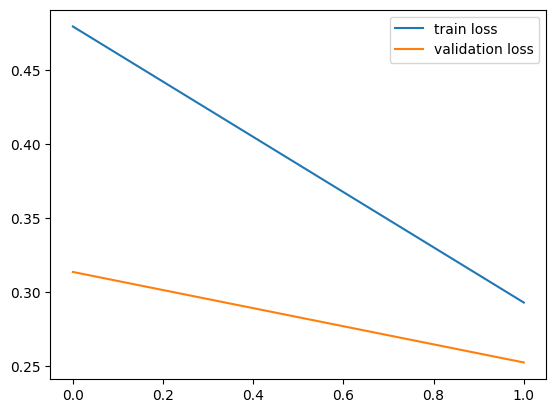

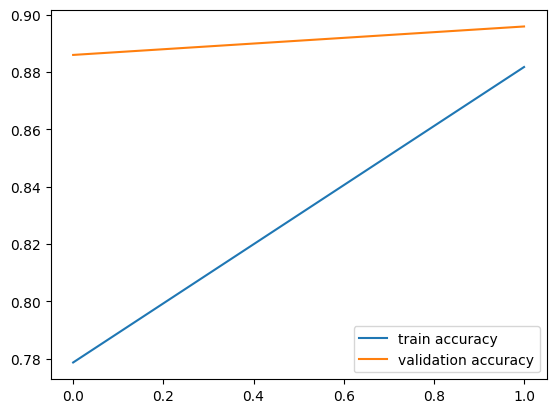

In [32]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [40]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

window_name = 'input_image'

cv2.imshow(window_name, input_image)

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 0:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

Path of the image to be predicted: image.jpg
1/1 [==============================] - 1s 991ms/step
[[0.17591153 0.7023457 ]]
1
The person in the image is not wearing a mask


In [39]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

window_name = 'input_image'

cv2.imshow(window_name, input_image)

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label ==1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

Path of the image to be predicted: rahul.jpg
1/1 [==============================] - 0s 63ms/step
[[0.23230146 0.6481701 ]]
1
The person in the image is wearing a mask
